Will investigate the following 2 reviewer comments here:
(1) Is it possible to optimize the geometry? Or transition states and reaction paths? Perhaps this is the next step, but it would be essential to map out how strong coupling affects chemistry. For the Mg-Br system, is there an effect of the strong coupling on the ground state equilibrium?

(2) Somewhat related to my previous comments on the field strength: The diffference between the simple Jaynes-Cummings-like model (eq. 22) and the CQED-CIS method is very interesting to see, but how strong does the field need to be in order to see these differences. Might it be that for moderate fields, which may be more in line with experiment, in particular for optical cavities, the differences would dissappear?
Still needs to be addressed.



In [1]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


Virtual photons in the resonant Lorentz model. a Number of photons in the resonant mode ck = ω 0 as a function of the coupling for γ L = 0 (thin blue line), 0.5ω 0 (solid cyan line), ω 0 (dash-dotted green line), 1.5ω 0 (dashed magenta line) and 2ω 0 (dotted red line)

We will explore the photon occupation in the ground state under different cavity coupling
and dissipation rates.  In particular, we will consider cavity coupling strengths $g$ relative 
to the photon energy / transition energy as follows:

$$ g = N\frac{\omega}{2}, $$
where $N = 0.5, 1, 1.5, 2$.

We can estimate $g$ as 

$$ g = \sqrt{\frac{\omega}{2}}\lambda \mu $$, 

where we can rearrange for $\lambda$:

$$ \lambda = \frac{f}{\mu \sqrt{\frac{1}{2\omega}}} $$
where $f = 0.25, 0.5, 0.75, 1.0$.

Additionally, we will consider an imaginary part of the frequency $\gamma$ such 
that 
$$ \gamma = m \omega, $$
where $m = 0.0, 0.5, 1.0, 1.5, 2.0$.

In [11]:
# template for z-matrix
molstr = """
Mg
H 1 2.2
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options
psi4.set_options(options_dict)

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# fix real part of omega
om_r = 4.75 / 27.211

# approximate max value of g
#g_max = np.sqrt(om_r/2) * lam_z * max_tdm

# this is a list of fraction values that is used to compute the value
# of \lambda such that the g/\omega is a fraction with the following magnitudes
f_list = np.array([0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,  0.5])

# this is a list of fraction values that is used to define the \gamma value
# relative to the real part of the frequency \omega
m_list = np.array([0, 0.5, 1.0, 1.5, 2.0])

# photon energy
om_r = 4.75 / 27.211

# define the different values of \lambda
lambda_list = f_list / (max_tdm * np.sqrt(1/(2 * om_r)))
print("lambda list")
print(lambda_list)


# get in terms of g
g_list = np.sqrt(om_r/2) * lambda_list * max_tdm
print("g list")
print(g_list)

# define the different values of \gamma
gamma_list = om_r * m_list
print("gamma list")
print(gamma_list)

relative_strength = np.zeros((len(m_list),len(f_list)))
# array to hold the cs-cqed-cis energies
#cqed_cis_energy_array = np.zeros((5, n_lam),dtype=complex)

# array to hold the photon occupations of the ground state
photon_occupation_L = np.zeros((len(m_list),len(f_list)))
photon_occupation_LR = np.zeros((len(m_list),len(f_list)))

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
n_state = 0
l_ctr = 0
mol = psi4.geometry(molstr)
e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
for l in lambda_list:
    lam = np.array([0, 0, l])
    #mol = psi4.geometry(molstr)
    #e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    g_ctr = 0
    for g in gamma_list:
        om = om_r - g/2 * 1j
        cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
        g_c = np.sqrt(om/2) * l * max_tdm
        relative_strength[g_ctr, l_ctr] = np.real( np.sqrt( np.conj(g_c) * g_c ))
        CL = cqed_dict['ORIGINAL L VECTROS']
        #CR = cqed_dict['CQED-CIS R VECTORS'] 
        #po_l = np.real(np.conj(CL[1,n_state]) * CL[1,n_state])
        #po_lr = np.real(np.conj(CL[1,n_state]) * CR[1,n_state])
        po_l = 0.
        for i in range(0, len(CL[:,0])):
            if i%2==1:
                po_l += np.real(np.conj(CL[i,n_state]) * CL[i,n_state])
        #        po_r += np.real(np.conj(CR[i,n_state]) * CR[i,n_state])
        photon_occupation_L[g_ctr, l_ctr] = po_l
        #photon_occupation_LR[g_ctr, l_ctr] = po_lr
        g_ctr += 1
    l_ctr += 1
    

    

 

lambda list
[0.         0.01313037 0.02626074 0.03939112 0.05252149 0.06565186
 0.07878223 0.09191261 0.10504298 0.11817335 0.13130372]
g list
[0.         0.00872809 0.01745618 0.02618426 0.03491235 0.04364044
 0.05236853 0.06109662 0.0698247  0.07855279 0.08728088]
gamma list
[0.         0.08728088 0.17456176 0.26184264 0.34912352]
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6658775695342456
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8639591041890924   dE = -1.99864E+02   dRMS = 4.60183E-08
SCF Iteration   2: Energy = -199.8639591041913661   dE = -2.27374E-12   dRMS = 1.41134E-08
Total time for SCF iterations: 0.008 seconds 

QED-RHF   energy: -199.86395910 hartree
Psi4  SCF energy: -199.86395910 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.665877569534245

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6665361572873394
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0041777355969790
SCF Iteration   1: Energy = -199.8611841601233436   dE = -1.99861E+02   dRMS = 1.11611E-04
SCF Iteration   2: Energy = -199.8612067072759260   dE = -2.25472E-05   dRMS = 4.14848E-05
SCF Iteration   3: Energy = -199.8612093192006682   dE = -2.61192E-06   dRMS = 1.55909E-05
SCF Iteration   4: Energy = -199.8612096855602545   dE = -3.66360E-07   dRMS = 5.90244E-06
SCF Iteration   5: Energy = -199.8612097382304569   dE = -5.26702E-08   dRMS = 2.24588E-06
Total time for SCF iterations: 0.011 seconds 

QED-RHF   energy: -199.86120974 hartree
Psi4  SCF energy: -199.86395910 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6665361572873394
Nu

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6685119205468482
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0167109423879162
SCF Iteration   1: Energy = -199.8528593279262680   dE = -1.99853E+02   dRMS = 4.46406E-04
SCF Iteration   2: Energy = -199.8532066296111509   dE = -3.47302E-04   dRMS = 1.55817E-04
SCF Iteration   3: Energy = -199.8532424974622757   dE = -3.58679E-05   dRMS = 5.70374E-05
SCF Iteration   4: Energy = -199.8532471756649329   dE = -4.67820E-06   dRMS = 2.10458E-05
SCF Iteration   5: Energy = -199.8532478141165143   dE = -6.38452E-07   dRMS = 7.85152E-06
SCF Iteration   6: Energy = -199.8532479033020763   dE = -8.91856E-08   dRMS = 2.95187E-06
Total time for SCF iterations: 0.014 seconds 

QED-RHF   energy: -199.85324790 hartree
Psi4  SCF energy: -199.86395910 hartree
C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron 

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6718048593126014
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0375996203728114
SCF Iteration   1: Energy = -199.8389846075975811   dE = -1.99839E+02   dRMS = 1.00440E-03
SCF Iteration   2: Energy = -199.8406366980010205   dE = -1.65209E-03   dRMS = 3.15891E-04
SCF Iteration   3: Energy = -199.8407768044910711   dE = -1.40106E-04   dRMS = 1.11318E-04
SCF Iteration   4: Energy = -199.8407932610471107   dE = -1.64566E-05   dRMS = 3.99611E-05
SCF Iteration   5: Energy = -199.8407953761321210   dE = -2.11509E-06   dRMS = 1.47362E-05
SCF Iteration   6: Energy = -199.8407956639231884   dE = -2.87791E-07   dRMS = 5.55880E-06
SCF Iteration   7: Energy = -199.8407957046785555   dE = -4.07554E-08   dRMS = 2.13017E-06
Total time for SCF iterations: 0.016 seconds 

QED-RHF   energy: -199.84079570 hartree
Psi4  SCF ene

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6739452695103978
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0511772610629933
SCF Iteration   1: Energy = -199.8299660393841179   dE = -1.99830E+02   dRMS = 1.36709E-03
SCF Iteration   2: Energy = -199.8329067591972716   dE = -2.94072E-03   dRMS = 4.02778E-04
SCF Iteration   3: Energy = -199.8331259261766490   dE = -2.19167E-04   dRMS = 1.38922E-04
SCF Iteration   4: Energy = -199.8331503142434542   dE = -2.43881E-05   dRMS = 4.95783E-05
SCF Iteration   5: Energy = -199.8331534037772883   dE = -3.08953E-06   dRMS = 1.85029E-05
SCF Iteration   6: Energy = -199.8331538332262198   dE = -4.29449E-07   dRMS = 7.17035E-06
SCF Iteration   7: Energy = -199.8331538971155510   dE = -6.38893E-08   dRMS = 2.85072E-06
Total time for SCF iterations: 0.018 seconds 

QED-RHF   energy: -199.83315390 hartree
Psi4  SCF ene

C
23
Cocc
23

Start SCF iterations:

Canonical RHF One-electron energy = -281.6658775695342456
CQED-RHF One-electron energy      = -281.6792139715356029
Nuclear repulsion energy          = 2.8864211491090908
Dipole energy                     = 0.0845991458388257
SCF Iteration   1: Energy = -199.8077664868586965   dE = -1.99808E+02   dRMS = 2.25988E-03
SCF Iteration   2: Energy = -199.8150596767484046   dE = -7.29319E-03   dRMS = 5.80099E-04
SCF Iteration   3: Energy = -199.8154620551016478   dE = -4.02378E-04   dRMS = 1.89890E-04
SCF Iteration   4: Energy = -199.8155036755935043   dE = -4.16205E-05   dRMS = 7.00280E-05
SCF Iteration   5: Energy = -199.8155093219758953   dE = -5.64638E-06   dRMS = 2.85710E-05
SCF Iteration   6: Energy = -199.8155102582666416   dE = -9.36291E-07   dRMS = 1.25232E-05
SCF Iteration   7: Energy = -199.8155104351327509   dE = -1.76866E-07   dRMS = 5.69632E-06
SCF Iteration   8: Energy = -199.8155104709740613   dE = -3.58413E-08   dRMS = 2.63104E-06
Total tim

No handles with labels found to put in legend.


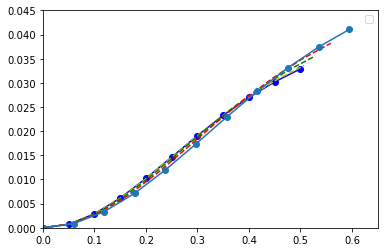

In [23]:


plt.plot(relative_strength[0,:]/om_r, photon_occupation_L[0,:], '-bo')
plt.plot(relative_strength[1,:]/om_r, photon_occupation_L[1,:], 'y--')
plt.plot(relative_strength[2,:]/om_r, photon_occupation_L[2,:], 'g--')
plt.plot(relative_strength[3,:]/om_r, photon_occupation_L[3,:], 'r--')
plt.plot(relative_strength[4,:]/om_r, photon_occupation_L[4,:], '-o')
#plt.plot(g_list/om_r, photon_occupation[2,:], 'ro')
#plt.plot(g_list/om_r, photon_occupation[3,:], 'o')
#plt.plot(g_list/om_r, photon_occupation[4,:], 'o')
plt.xlim(0,0.65)
plt.ylim(0,0.045)
plt.legend()
plt.show()

#|c_o^1|^2

In [ ]:
import scipy.linalg as la
D_1 = np.outer( CL[:,0], CR[:,0])
D_2 = np.outer( CR[:,0], np.conj(CL[:,0]))
D_3 = np.outer( CL[:,0], np.conj(CL[:,0]))

H = cqed_dict['CQED-CIS H MATRIX']
ECIS, L_CCIS, R_CCIS = la.eig(H, left=True, right=True)
idx = ECIS.argsort()
ECIS = ECIS[idx]
L_CCIS = L_CCIS[:, idx]
R_CCIS = R_CCIS[:, idx]
D_L = np.outer(L_CCIS[:,0], np.conj(L_CCIS[:,0]))

sm = 0.
sm_l = 0.
for i in range(0, len(D_2)):
    if i%2==1:
        sm += D_2[i,i]
        sm_l += D_L[i,i]
print("printing various traces")
print(sm)
print(sm_l)
print(sm/np.trace(D_2))
print(D_2[1,1])
#print(np.trace(D_1))
#print(np.trace(D_2))
#print(np.trace(D_3))

print(np.trace(D_L))

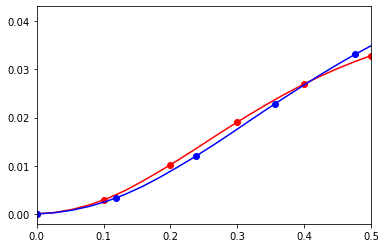

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline
g0_spline = InterpolatedUnivariateSpline(relative_strength[0,:]/om_r, photon_occupation_L[0,:], k=2)
g1_spline = InterpolatedUnivariateSpline(relative_strength[1,:]/om_r, photon_occupation_L[1,:], k=2)
g2_spline = InterpolatedUnivariateSpline(relative_strength[2,:]/om_r, photon_occupation_L[2,:], k=2)
g3_spline = InterpolatedUnivariateSpline(relative_strength[3,:]/om_r, photon_occupation_L[3,:], k=2)
g4_spline = InterpolatedUnivariateSpline(relative_strength[4,:]/om_r, photon_occupation_L[4,:], k=2)

g_fine = np.linspace(0, 0.5, 20)

plt.plot(g_fine, g0_spline(g_fine), 'red')
plt.plot(relative_strength[0,:]/om_r, photon_occupation_L[0,:], 'ro')
plt.plot(g_fine, g4_spline(g_fine), 'blue')
plt.plot(relative_strength[4,:]/om_r, photon_occupation_L[4,:], 'bo')
plt.xlim(0,0.5)
plt.show()


In [ ]:
f = open('MgH_ccpVDZ_Ez_12.5mH_om_4.75_0g.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; JC LP; JC UP; PF LP; PF UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
            np.real(jc[0,ctr]),np.real(jc[1,ctr]), 
            np.real(pf[1,ctr]),np.real(pf[2,ctr]),
            np.real(cqed_cis_energy_array[1,ctr]),np.real(cqed_cis_energy_array[2,ctr])))
    ctr += 1
    
f.close()

Run the cell below to compute the data for Figure 2: scan of ground-state energy
of MgH+ coupled to a photon with energy 4.75 eV and lambda = 0.075 atomic units polarized along z
at the RHF/cc-pVDZ, CQED-RHF/cc-pVDZ, and CQED-CIS/cc-pVDZ levels.

Write the data to a file!

In [ ]:
# plot the ground-state potential energy surfaces
plt.plot(r_array, gs_energy_array[0,:], label='RHF')
plt.plot(r_array, gs_energy_array[1,:], label='CQED-RHF')
plt.plot(r_array, gs_energy_array[2,:], label='CQED-CIS')
plt.legend()
plt.show()


In [ ]:
# write the data to file!
f = open('MgH_gs_lamz_7.5mH_om_4.75.txt', 'w')
stri = "r; rhf_e, cqed_rhf_e, cqed_cis_e"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f \n" % 
            (r, gs_energy_array[0,ctr], gs_energy_array[1,ctr], gs_energy_array[1,ctr]+gs_energy_array[2,ctr]))
    ctr += 1
    
f.close()